LA PARTE DE CHEQUEO DE NULOS, VALORES DUPLICADOS, VALORES FALTANTES, TIPOS DE DATOS, ETC. SE ENCUENTRAN EN ETL.ipynb

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import gzip

# Carga los DataFrame desde el archivo CSV
df_reviews = pd.read_csv('Data/australian_user_reviews_ok.csv')
df_steam = pd.read_csv('Data/steam_games_ok.csv')
with gzip.open('Data/data_users_items_ok.csv.gz', 'rt') as f:
    df_items = pd.read_csv(f)

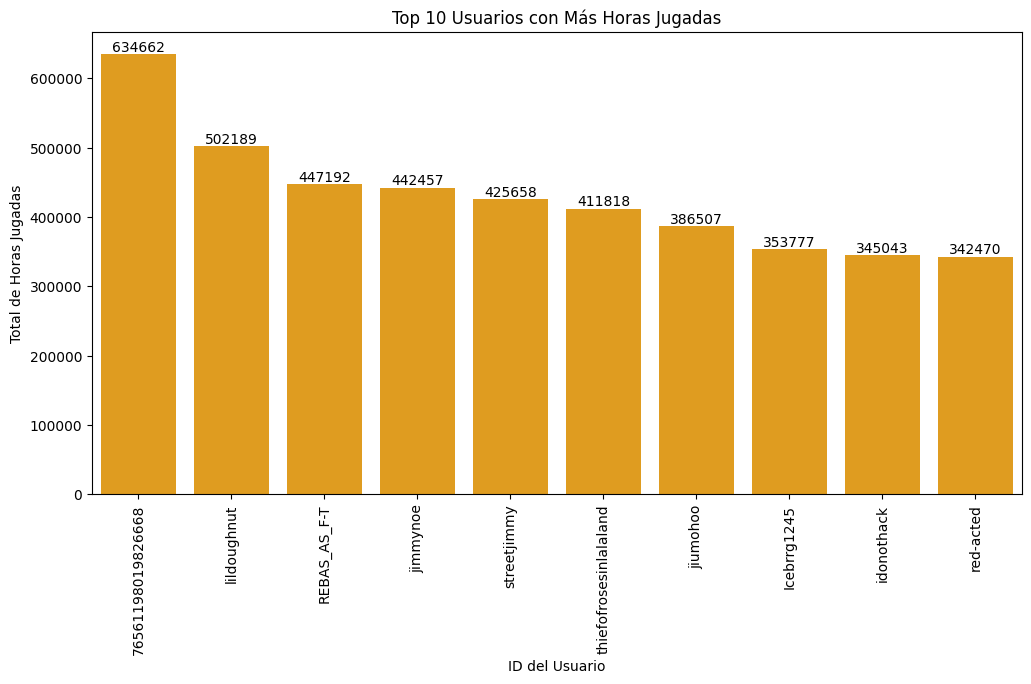

In [10]:
# Calcular la suma total de horas jugadas por usuario
total_horass_jugadas = df_items.groupby('user_id')['playtime_forever'].sum().reset_index()
# Ordenar los usuarios por horas jugadas de manera descendente y tomar los top 10
top_10_users_playtime = total_horass_jugadas.sort_values(by='playtime_forever', ascending=False).head(10)

# Crear un gráfico de barras para visualizar el top 10 de usuarios con más horas jugadas
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='user_id', y='playtime_forever', data=top_10_users_playtime, color='orange', order=top_10_users_playtime['user_id'])
plt.xticks(rotation=90)
plt.xlabel('ID del Usuario')
plt.ylabel('Total de Horas Jugadas')
plt.title('Top 10 Usuarios con Más Horas Jugadas')

# Agregar etiquetas a las barras
for index, value in enumerate(top_10_users_playtime['playtime_forever']):
    bar_plot.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

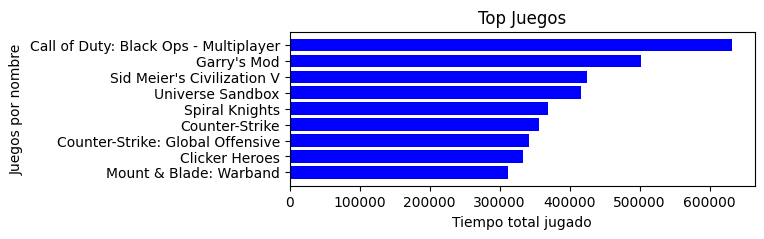

In [2]:
#Los juegos con mayor tiempo jugado
top_playtime = df_items.sort_values(by='playtime_forever', ascending=False).head(10)

# Creamos un gráfico de barras para visualizar el top 10 de juegos con mas horas jugadas
plt.figure(figsize=(6, 2))  
plt.barh(top_playtime['item_name'], top_playtime['playtime_forever'], color='blue')
plt.xlabel('Tiempo total jugado')  
plt.ylabel('Juegos por nombre')         
plt.title('Top Juegos') 
plt.gca().invert_yaxis()  
plt.show()

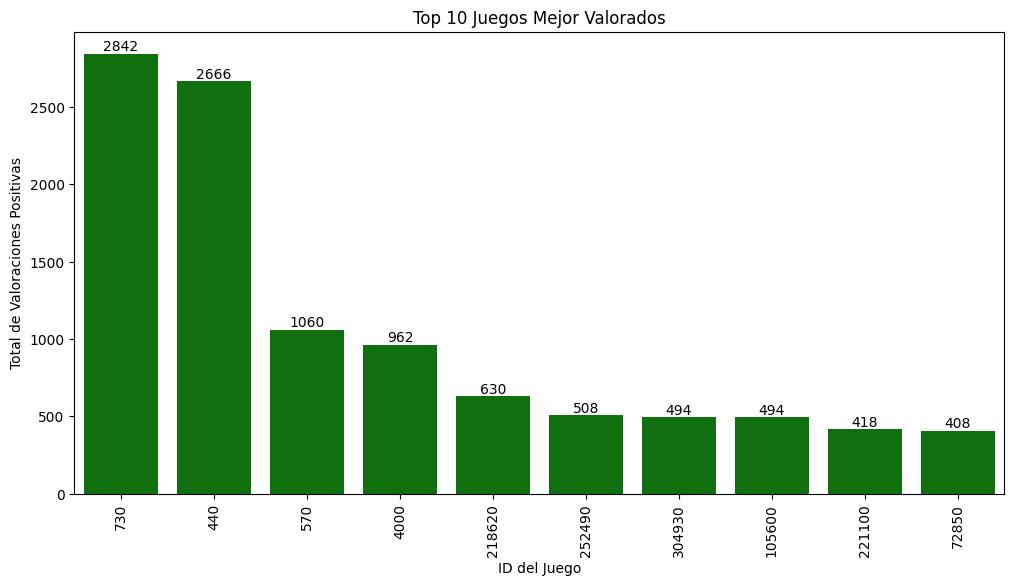

In [11]:
# Filtramos para obtener solo los juegos con sentiment_analysis mayor a 1
df_mejor_valorados = df_reviews[df_reviews['sentiment_analysis'] > 1]
# Contamos la cantidad total de valoraciones positivas por juego
cantidad_valoraciones = df_mejor_valorados.groupby('item_id')['sentiment_analysis'].sum().reset_index()
# Ordenamos los juegos por cantidad total de valoraciones de manera descendente y tomamos los top 10
top_10_mejor_valorados = cantidad_valoraciones.sort_values(by='sentiment_analysis', ascending=False).head(10)

# Crear un gráfico de barras para visualizar el top 10 de juegos mejor valorados
plt.figure(figsize=(12, 6))
bar_plot = sns.barplot(x='item_id', y='sentiment_analysis', data=top_10_mejor_valorados, color='green', order=top_10_mejor_valorados['item_id'])
plt.xticks(rotation=90)
plt.xlabel('ID del Juego')
plt.ylabel('Total de Valoraciones Positivas')
plt.title('Top 10 Juegos Mejor Valorados')

# Agregar etiquetas a las barras
for index, value in enumerate(top_10_mejor_valorados['sentiment_analysis']):
    bar_plot.text(index, value + 0.1, str(value), ha='center', va='bottom')

plt.show()

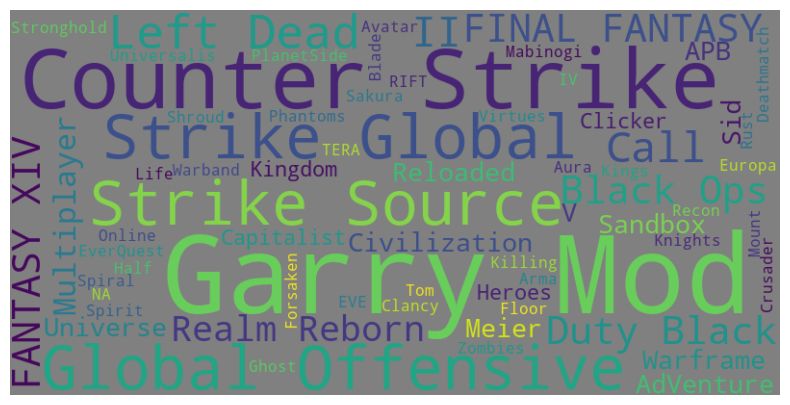

In [23]:
# Nube de palabras para los títulos de Video Juegos
top_playtime = df_items.sort_values(by='playtime_forever', ascending=False).head(100)
title_wordcloud = WordCloud(width=800, height=400, background_color='grey').generate(' '.join(top_playtime['item_name']))
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

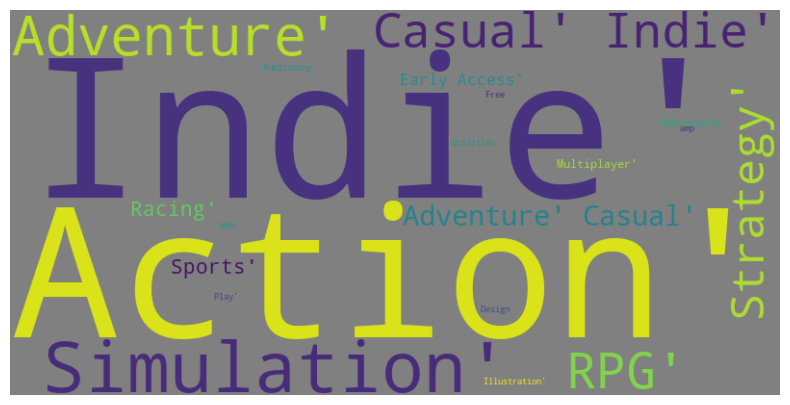

In [25]:
# Nube de palabras para los generos de Video Juegos
top_genero = df_steam.sort_values(by='playtime_forever', ascending=False).head(100)
title_wordcloud = WordCloud(width=800, height=400, background_color='grey').generate(' '.join(top_genero['genres']))
plt.figure(figsize=(10, 5))
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [39]:
tipos_de_datos = df_steam.dtypes
print(tipos_de_datos)

genres              object
app_name            object
release_date         int64
tags                object
id                   int64
playtime_forever     int64
dtype: object


In [10]:
df_reviews

,user_id,sentiment_analysis,item_id,recommend,año_posted
0,76561197970982479,2,1250,1,2011
1,js41637,2,251610,1,2014
2,evcentric,2,248820,1,Sin dato
3,doctr,2,250320,1,2013
4,maplemage,1,211420,1,2014
...,...,...,...,...,...
25453,76561198306599751,2,261030,1,Sin dato
25454,Ghoustik,1,730,1,Sin dato
25455,76561198310819422,2,570,1,Sin dato
25456,76561198312638244,2,233270,1,Sin dato


In [1]:
# funcion para comprimir con gzip
import gzip
import shutil

def comprimir_a_gzip(archivo_entrada, archivo_salida):
    with open(archivo_entrada, 'rb') as f_in:
        with gzip.open(archivo_salida, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

In [2]:
archivo_csv = 'G:\\PI MLOps - STEAM\\Data\\data_users_items_ok.csv'
archivo_gzip = 'G:\\PI MLOps - STEAM\\Data\\data_users_items_ok.csv.gz'

comprimir_a_gzip(archivo_csv, archivo_gzip)

In [ ]:
# funcion para descomprimir un gz

import gzip
import pandas as pd

def leer_csv_gzip(archivo_gzip):
    with gzip.open(archivo_gzip, 'rt') as f:
        # 'rt' indica que el archivo está en modo de texto
        df = pd.read_csv(f)
    return df

# Ejemplo de uso
archivo_gzip = 'G:\\PI MLOps - STEAM\\Data\\data_users_items_ok.csv.gz'
datos = leer_csv_gzip(archivo_gzip)

# Ahora 'datos' es un DataFrame de pandas con el contenido del archivo CSV
